In [3]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [4]:
import copy
from hexalattice.hexalattice import *


__proj_dir__ = "C:\\Users\\admin\\Desktop\\Capstone"

def target_height_to_box_dim_RDG6(target_height, target_height_is_in_cells=False):
    '''Returns cell width, depth, height given target height'''
    if target_height_is_in_cells:
        target_height *= np.sqrt(6)/3

    return round(target_height*2), round(target_height*4*np.sqrt(3)/3), round(target_height*3/np.sqrt(6))

def target_height_to_box_dim_RDG4(target_height, target_height_is_in_cells=False):
    '''Returns cell width, depth, height given target height'''

    if target_height_is_in_cells:
        target_height /= np.sqrt(2)

    return round(target_height*2), round(target_height*2), round(target_height*np.sqrt(2))

def boxdim_to_real_distance_RDG6(dims):
    '''Returns real distance given box dimensions'''
    return (dims[0], dims[1]*3/(2*np.sqrt(3)), dims[2]*np.sqrt(6)/3)

def boxdim_to_real_distance_RDG4(dims):
    '''Returns real distance given box dimensions'''
    return (dims[0], dims[1], (dims[2]-1)*np.sqrt(2)/2 + np.sqrt(2))

def hex_indices_to_coords(x,y):
    return np.array([x*3/(2*np.sqrt(3)), y - 0.5*x])

# Visualize data
def visualize_data(N, nu, threshold, shape_name, N_is_cellcount = False, show_colorbar=True):
    shape_name_str = shape_name
    N_str = str(N)
    if shape_name == "Cube":
        shape_name_str = "Cube\\x2_widths"
        N_str = str(N)
        width = 2*N
    elif shape_name == "RDG4":
        shape_name_str = "RDG_square_int"
        N_str = f"{round(2*N)}x{round(2*N)}x{round(N*np.sqrt(2))}"
        width = int(2*N)
    elif shape_name == "RDG6":
        visualize_hexagon_data(N, nu, threshold, N_is_cellcount)
        return
    else:
        print(f"{shape_name} is not one of the stored grid-types (Cube, RDG4, RDG6)")
        return

    filename_strike = f"{__proj_dir__}\\data\\{shape_name_str}\\{N_str}_{nu}_{threshold}_strikedata.txt"
    strike_file = open(filename_strike,'r')
    strike_data_str = strike_file.read()
    strike_data_str = strike_data_str.split('#')[:-1]

    strike_data = np.zeros((width, width))
    print("Datapoints:",len(strike_data_str))

    for point in strike_data_str:
        point = point.split(',')
        x_coord = ...
        y_coord = ...
        if shape_name == "Cube":
            x_coord = point[1]
            y_coord = point[2]
        elif shape_name == "RDG4" or shape_name == "RDG6":
            x_coord = point[0]
            y_coord = point[1]
        x_coord = x_coord.strip()
        if shape_name == "RDG4" or shape_name == "RDG6":
            x_coord = x_coord.strip('(')
            x_coord = x_coord.strip()
        y_coord = y_coord.strip()
        y_coord = y_coord.strip(')')
        strike_data[int(x_coord), int(y_coord)] += 1

    plt.imshow(strike_data, cmap="plasma")
    if show_colorbar:
        plt.colorbar()
    plt.show()


# Visualize hexagon data
def visualize_hexagon_data(N, nu, threshold, N_is_cellcount = False):
    def float_to_rgb_color(value, cmap_name='viridis'):
        value = min(0.9999999999, max(0, value))
        
        cmap = plt.get_cmap(cmap_name)
        
        rgba = cmap(value)
        
        return [rgba[0], rgba[1], rgba[2]]


    width, depth, height = target_height_to_box_dim_RDG6(N)

    filename_strike = f"{__proj_dir__}\\data\\RDG_hex_int\\{width}x{depth}x{height}_{nu}_{threshold}_strikedata.txt"
    strike_file = open(filename_strike,'r')
    strike_data_str = strike_file.read()
    strike_data_str = strike_data_str.split('#')[:-1]

    width_max = width*2+1
    depth_max = depth*3//2
    strike_data = np.zeros((width_max, depth_max))
    print("Datapoints:", len(strike_data_str))

    for point in strike_data_str:
        point = point.split(',')
        x_coord = point[0]
        y_coord = point[1]
        x_coord = x_coord.strip()
        x_coord = x_coord.strip('(')
        y_coord = y_coord.strip()
        y_coord = y_coord.strip(')')
        strike_data[int(x_coord), int(y_coord)] += 1

    strike_data /= np.max(strike_data)


    hex_centers, _ = create_hex_grid(nx=width_max,
                                     ny=depth_max,
                                     do_plot=False)
    x_hex_coords = hex_centers[:, 0]
    x_hex_coords = np.array([val - i//(width_max) + (i*1)//(2*width_max) for i, val in enumerate(x_hex_coords)])
    y_hex_coords = hex_centers[:, 1]


    colors = np.array([float_to_rgb_color(strike_data[x_pos, y_pos], cmap_name='plasma') for y_pos in range(depth_max) for x_pos in range(width_max)])
    edge_colors = copy.deepcopy(colors)

    new_edge_colors = []
    new_colors = []
    new_x_hex_coords = []
    new_y_hex_coords = []

        
    effective_width = width//2+1
    y_pos_cells = width*2//3
    effective_depth = y_pos_cells * np.sqrt(3)/2
    diff = int(effective_depth - effective_width)
    effective_width += diff
    
    total_weight = np.sum(strike_data)
    mid_x = np.sum(np.arange(strike_data.shape[0])[:, None] * strike_data) / total_weight
    mid_y = np.sum(np.arange(strike_data.shape[1]) * strike_data) / total_weight
    mid_x_coord = x_hex_coords[int(mid_x) + int(mid_y) * width_max]
    mid_y_coord = y_hex_coords[int(mid_x) + int(mid_y) * width_max]
    
    left_boundary = mid_y_coord - width/2
    right_boundary = mid_y_coord + width/2
    top_boundary = mid_x_coord - depth//2 + 1
    bottom_boundary = mid_x_coord + depth//2 - 1
    print(width, depth, height)

    for x_pos in range(width_max):
        for y_pos in range(depth_max):
            if y_hex_coords[y_pos + y_pos * width_max] < left_boundary or \
                y_hex_coords[y_pos + y_pos * width_max] > right_boundary or \
                x_hex_coords[x_pos + y_pos * width_max] < top_boundary or \
                x_hex_coords[x_pos + y_pos * width_max] > bottom_boundary:
                continue
            new_edge_colors.append(edge_colors[x_pos + y_pos * width_max])
            new_colors.append(colors[x_pos + y_pos * width_max])
            new_x_hex_coords.append(x_hex_coords[x_pos + y_pos * width_max])
            new_y_hex_coords.append(y_hex_coords[y_pos + y_pos * width_max])

    new_edge_colors = np.array(new_edge_colors)
    new_colors = np.array(new_colors)
    new_x_hex_coords = np.array(new_x_hex_coords)
    new_y_hex_coords = np.array(new_y_hex_coords)
    new_x_hex_coords += depth-2
    new_y_hex_coords += width - 6*mid_y_coord - 2

    plot_single_lattice_custom_colors(new_y_hex_coords, new_x_hex_coords,
                                        face_color=new_colors,
                                        edge_color=new_colors,
                                        min_diam=0.99,
                                        plotting_gap=0.04,
                                        rotate_deg=30)
    plt.show()


In [5]:
from scipy.stats import chi2
from scipy.stats import pearsonr

# Variance of 2D data
def error_from_indices(pos_a, pos_b):
    '''positions assumed to be (x-pos, y-pos)'''
    euclidian_pos_a = hex_indices_to_coords(*pos_a)
    euclidian_pos_b = hex_indices_to_coords(*pos_b)
    error = np.sum((euclidian_pos_a - euclidian_pos_b)**2)
    return error

def calc_variance(N, nu, threshold, shape_name, print_output=False, N_is_cellcount = False, datapoints_count=200):
    if shape_name == "Cube":
        shape_name_str = "Cube\\x2_widths"
        N_str = str(N)
        strike_arr_width = 2*N
    elif shape_name == "RDG4":
        shape_name_str = "RDG_square_int"
        width, depth, height = target_height_to_box_dim_RDG4(N, target_height_is_in_cells=N_is_cellcount)
        N_str = f"{width}x{depth}x{height}"
        strike_arr_width= width
    elif shape_name == "RDG6":
        shape_name_str = "RDG_hex_int"
        width, depth, height = target_height_to_box_dim_RDG6(N, target_height_is_in_cells=N_is_cellcount)
        N_str = f"{width}x{depth}x{height}"
        strike_arr_width = max(width*2+1, depth*3//2)
    else:
        print(f"{shape_name} is not one of the stored grid-types (Cube, RDG4, RDG6)")
        return

    filename_strike = f"{__proj_dir__}\\data\\{shape_name_str}\\{N_str}_{nu}_{threshold}_strikedata.txt"
    strike_file = open(filename_strike,'r')
        
    strike_data_str = strike_file.read()
    strike_data_str = strike_data_str.split('#')[:-1]

    strike_data = np.zeros((strike_arr_width, strike_arr_width), dtype=int)

    if datapoints_count > len(strike_data_str):
        print(shape_name, N, len(strike_data_str))
    else:
        strike_data_str = strike_data_str[:datapoints_count]

    for i, point in enumerate(strike_data_str):
        
        point = point.split(',')
        if shape_name == "Cube":
            x_coord = point[1]
            y_coord = point[2]
            if i == 0:
                height = int(point[0].strip('(').strip())
                real_height = height

        elif shape_name == "RDG4" or shape_name == "RDG6":
            x_coord = point[0]
            y_coord = point[1]
            if i == 0:
                height = int(point[2].strip(')').strip())
                if shape_name == "RDG4":
                    real_height = height / np.sqrt(2)
                else:
                    real_height = height * np.sqrt(3)/np.sqrt(2)
        x_coord = x_coord.strip()
        if shape_name == "RDG4" or shape_name == "RDG6":
            x_coord = x_coord.strip('(')
        y_coord = y_coord.strip()
        y_coord = y_coord.strip(')')
        strike_data[int(x_coord), int(y_coord)] += 1
    
    indices = np.nonzero(strike_data)
    y_indices, x_indices = indices

    if shape_name == "RDG6":
        # Convert data to a list of x-positions and one of y-positions

        # height = sqrt(3) * radius = 1
        # radius = 1/sqrt(3)
        # x_pos_change = 3/2 * radius = 3/(2*sqrt(3))
        # A vertical move will only change y-pos with +1
        # A horizontal move will move y-pos with -1/2, and x-pos with 3/(2*sqrt(3))
        
        # Collect all strike positions in euclidian coordinates 
        all_positions = []
        for i in range(len(indices[0])):
                y_i, x_i = indices[0][i], indices[1][i]
                all_positions.extend([hex_indices_to_coords(x_i, y_i)]*strike_data[y_i, x_i])
                
        x_positions = [pos[0] for pos in all_positions]
        y_positions = [pos[1] for pos in all_positions]
        mean_x_pos = np.mean(x_positions)
        mean_y_pos = np.mean(y_positions)
        var_x_pos = np.var(x_positions)
        var_y_pos = np.var(y_positions)
        mean_pos = mean_x_pos, mean_y_pos

        # make a list of all errors
        all_errors = []
        for pos in all_positions:
            all_errors.append(error_from_indices(pos, mean_pos))

        overall_var = np.mean(all_errors)/2
        var_overall_var = np.var(all_errors)

    else:
        # sum all rows
        x_data_flat = np.sum(strike_data, axis=1)
        # sum all columns
        y_data_flat = np.sum(strike_data, axis=0)

        # Produce a list where number of elements with index value is proportional to strike_data value
        multiple_x_indices = []
        for x in x_indices:
            multiple_x_indices.extend([x]*x_data_flat[x])

        multiple_y_indices = []
        for y in y_indices:
            multiple_y_indices.extend([y]*y_data_flat[y])

        # Average x and y pos, variance of center
        mean_x_pos = np.mean(multiple_x_indices)
        mean_y_pos = np.mean(multiple_y_indices)
        var_x_pos = np.var(multiple_x_indices)
        var_y_pos = np.var(multiple_y_indices)

        # Overall variance (average error)
        x_distances = []
        y_distances = []
        all_errors = []
        for x in range(strike_arr_width):
            for y in range(strike_arr_width):
                if strike_data[x,y] > 0:
                    # Error in x, y, and overall 
                    x_distances.extend([(x - mean_x_pos)**2] * strike_data[y,x])
                    y_distances.extend([(y - mean_y_pos)**2] * strike_data[y,x])
                    all_errors.extend([((x - mean_x_pos)**2 + (y - mean_y_pos)**2)] * strike_data[y,x])
        
        # Average error
        var_x_pos = np.mean(x_distances)
        var_y_pos = np.mean(y_distances)
        overall_var = np.mean(np.array(all_errors)/2)


        all_positions = []
        for i in range(len(indices[0])):
            y_i, x_i = indices[0][i], indices[1][i]
            all_positions.extend([[x_i, y_i] for _ in range(strike_data[y_i, x_i])])
                

    # Calculate covariance matrix, pearson's r, and p-vale for covariance
    for i in range(len(all_positions)):
        all_positions[i] = np.array(all_positions[i]) - np.array([mean_x_pos, mean_y_pos])
    cov_matrix = np.cov(all_positions, rowvar=False)
    
    all_positions = np.array(all_positions)
    # Calculate the Pearson correlation coefficient and p-value
    corr_coefficient, corr_p_value = pearsonr(all_positions[:,0], all_positions[:,1])

    if print_output:
        print("Datapoints:", len(strike_data_str))
        print(f"Mean x-pos: {mean_x_pos}")
        print(f"Mean y-pos: {mean_y_pos}")
        print(f"Var x-pos: {var_x_pos}")
        print(f"Var y-pos: {var_y_pos}")
        print(f"Overall variance: {overall_var}")
        
        if shape_name != "RDG6":
            print("Variance of variances:")
            print(np.var(x_distances))
            print(np.var(y_distances))
            print(np.var(np.array(all_errors)/np.sqrt(2)))
        else:
            print(f"Variance of var: {var_overall_var}")

        print()
        print("cov_matrix:")            
        print(cov_matrix)            
        print()
        print("Pearson's r: ", corr_coefficient)
        print("Pearson's r p-value: ", corr_p_value)
        print()
        print("height of box in cells:", height)
        print("height of box in distance:", real_height)

    # Calculate 95% confidence interval for variance
    sample_variance = overall_var
    dof = len(strike_data_str) - 1
    a, b = chi2.ppf(0.975, dof), chi2.ppf(0.025, dof)

    lower_bound = (dof * sample_variance) / a
    upper_bound = (dof * sample_variance) / b
    
    return overall_var, lower_bound, upper_bound, var_x_pos, var_y_pos, mean_x_pos, mean_y_pos, all_errors

Datapoints: 3184


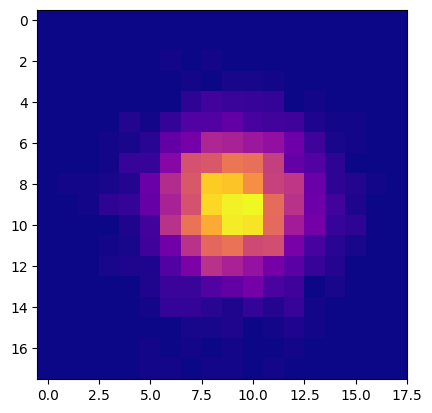

In [6]:
visualize_data(9, 6, 0.001, "RDG4", show_colorbar=False)

In [7]:
calc_variance(10, 6, 0.001, "RDG6", True);

Datapoints: 200
Mean x-pos: 15.791973238009241
Mean y-pos: 9.4675
Var x-pos: 3.26233125
Var y-pos: 3.00269375
Overall variance: 3.269934493604269
Variance of var: 75.93242873054552

cov_matrix:
[[ 3.27872487 -0.27622511]
 [-0.27622511  3.01778266]]

Pearson's r:  -0.08781459286898313
Pearson's r p-value:  0.21627580170112304

height of box in cells: 11
height of box in distance: 13.472193585307478


In [8]:
# Cube 30 means 60x60x30

# RDG4 30 means 45x45x30 
# side step is (r,r,0) -> sqrt(2)r = 1 -> r=1/sqrt(2)=sqrt(2)/2
# step up is (r,0,0) -> r -> 1/sqrt(2)
# so 45x45x30 is in rectangular coords 45x45x(30/sqrt(2)) -> 45x45x21.22

# RDG6 30 means 30x30x(11)
# side step is (r, r, 0) -> sqrt(2)r = 1 -> r=1/sqrt(2)
# two forward steps are (2r, 0, 0) = 2r = sqrt(2)
# step up is (r, r, r) -> sqrt(3)r = sqrt(3)/sqrt(2)
# so a x b x c -> (a*sqrt(2)) x b x (c*sqrt(3)/sqrt(2))

# For a given target width X
# I need Cube X x X x X/2

# q/sqrt(2) = X/2
# I need RDG4 X x X x X*sqrt(2)/2

# I need RDG6 X/sqrt(2) x X x X*sqrt(2)/(2*sqrt(3))

target_height = 9

print("Cell dimensions:")
print(f"Cube: {target_height*2}x{target_height*2}x{target_height}  ->  ({target_height*2}x{target_height*2}x{target_height})")
dims_cells = target_height_to_box_dim_RDG4(target_height)
dims_real = boxdim_to_real_distance_RDG4(dims_cells)
print(f"RDG4: {dims_cells[0]}x{dims_cells[1]}x{dims_cells[2]}  ->  ({dims_real[0]}x{round(dims_real[1], 2)}x{round(dims_real[2], 2)})")
dims_cells = target_height_to_box_dim_RDG6(target_height)
dims_real = boxdim_to_real_distance_RDG6(dims_cells)
print(f"RDG6: {dims_cells[0]}x{dims_cells[1]}x{dims_cells[2]}  ->  ({dims_real[0]}x{round(dims_real[1], 2)}x{round(dims_real[2], 2)})")

x = int(target_height*np.sqrt(2))
print(x)
print((x-1)*np.sqrt(2)/2 + np.sqrt(2))

x = int(target_height*np.sqrt(3)/np.sqrt(2))
print(x)
print((x-1)*np.sqrt(6)/3 + np.sqrt(6)/2)

x = 20
print()
print(f"Height of {x} cube cells: {x}")
print(f"Height of {x} RDG4 cells: {round((x+1)/np.sqrt(2), 2)}")
print(f"Height of {x} RDG6 cells: {round((x-1)*np.sqrt(6)/3 + np.sqrt(6)/2, 2)}")
print(2 * np.sqrt(3)/np.sqrt(2) + 1 * np.sqrt(6)/4)

Cell dimensions:
Cube: 18x18x9  ->  (18x18x9)
RDG4: 18x18x13  ->  (18x18x9.9)
RDG6: 18x21x11  ->  (18x18.19x8.98)
12
9.19238815542512
11
9.38971068066885

Height of 20 cube cells: 20
Height of 20 RDG4 cells: 14.85
Height of 20 RDG6 cells: 16.74
3.0618621784789726


In [9]:
# Compare the variances, and variance of variances, for a given target width

# width = 1
# size = 1/sqrt(3)
# vertical_change = 3/2 * size = 3/(2*sqrt(3))


Datapoints: 1344


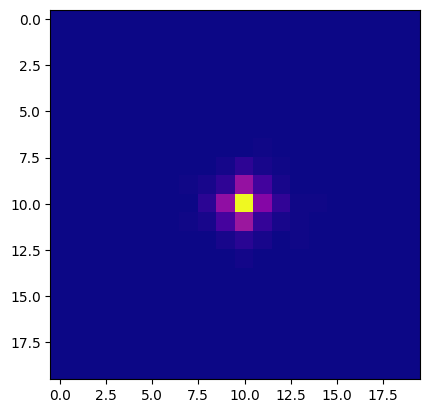

Datapoints: 2121


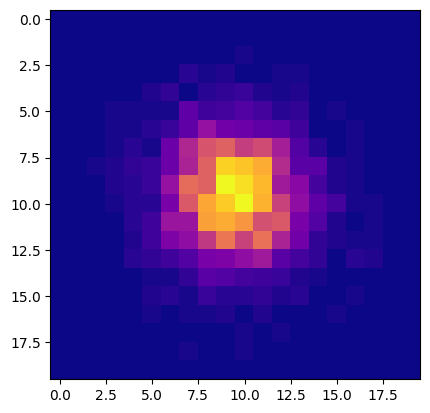

Datapoints: 606
20 23 12


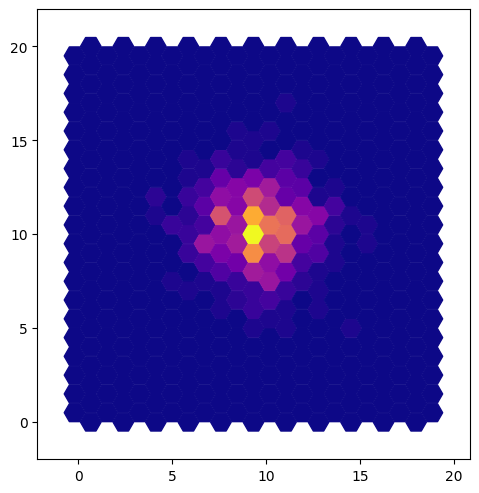

Cube stats
Datapoints: 200
Mean x-pos: 10.075996292863763
Mean y-pos: 9.979529170931423
Var x-pos: 0.5579436234467463
Var y-pos: 0.744032694879387
Overall variance: 0.6509881591630666
Variance of variances:
0.8771032963420506
1.0879583845399825
0.8714149207445243

cov_matrix:
[[ 0.71836683 -0.08100503]
 [-0.08100503  0.95316583]]

Pearson's r:  -0.09789366587274204
Pearson's r p-value:  0.16787549636371327

height of box in cells: 9
height of box in distance: 9


RDG4 stats
Datapoints: 200
Mean x-pos: 9.582227351413733
Mean y-pos: 9.484137055837563
Var x-pos: 3.6536997595445726
Var y-pos: 3.946121828791555
Overall variance: 3.799910794168063
Variance of variances:
28.47171879285731
30.077752149117536
32.22384798361171

cov_matrix:
[[4.32160804 0.65226131]
 [0.65226131 5.55015075]]

Pearson's r:  0.13318230862449632
Pearson's r p-value:  0.06009983682830601

height of box in cells: 13
height of box in distance: 9.192388155425117


RDG6 stats
Datapoints: 200
Mean x-pos: 15.79197323800924

In [10]:
target_analysis_height = 10
visualize_data(target_analysis_height, 6, 0.001, "Cube", show_colorbar=False)
visualize_data(target_analysis_height, 6, 0.001, "RDG4", show_colorbar=False)
visualize_data(target_analysis_height, 6, 0.001, "RDG6", show_colorbar=False)

print("Cube stats")
calc_variance(target_analysis_height, 6, 0.001, "Cube", True);
print("\n\nRDG4 stats")
calc_variance(target_analysis_height, 6, 0.001, "RDG4", True);
print("\n\nRDG6 stats")
calc_variance(target_analysis_height, 6, 0.001, "RDG6", True);

In [11]:
def plot_variance_plot(target_heights, height_is_cellcount, datapoints_count=200):
    if height_is_cellcount:
        RDG4_heights = target_heights[:]
        RDG6_heights = target_heights[:]
    else:
        RDG4_heights = [boxdim_to_real_distance_RDG4(target_height_to_box_dim_RDG4(target_height))[2] for target_height in target_heights]
        RDG6_heights = [boxdim_to_real_distance_RDG6(target_height_to_box_dim_RDG6(target_height))[2] for target_height in target_heights]
    true_heights_of_type_target = {"Cube": target_heights[:], "RDG4": RDG4_heights, "RDG6": RDG6_heights}
    true_heights_of_type = {"Cube": [], "RDG4": [], "RDG6": []}
    variances = {"Cube": [], "RDG4": [], "RDG6": []}
    lower_bounds = {"Cube": [], "RDG4": [], "RDG6": []}
    upper_bounds = {"Cube": [], "RDG4": [], "RDG6": []}

    for grid_type in ["Cube", "RDG4", "RDG6"]:
        for i, target_height in enumerate(target_heights):
            try:
                if grid_type == "RDG4" and not height_is_cellcount:
                    if  target_height in [10, 15, 20]:
                        target_height -= 1
                        true_heights_of_type_target[grid_type][i] = boxdim_to_real_distance_RDG4(target_height_to_box_dim_RDG4(target_height))[2]
                results = calc_variance(target_height, 6, 0.001, grid_type, N_is_cellcount=height_is_cellcount, datapoints_count=datapoints_count)
                variances[grid_type].append(results[0])
                lower_bounds[grid_type].append(results[1])
                upper_bounds[grid_type].append(results[2])
                true_heights_of_type[grid_type].append(true_heights_of_type_target[grid_type][i])
            except:
                print(f"No data for {grid_type} with height {target_height}")


    whisker_width=0.5
    plt.scatter(true_heights_of_type["Cube"], variances["Cube"], color="red", label="Cube")
    for i in range(len(true_heights_of_type["Cube"])):
        plt.plot([true_heights_of_type["Cube"][i], true_heights_of_type["Cube"][i]], [lower_bounds["Cube"][i], upper_bounds["Cube"][i]], color="red")
        plt.plot([true_heights_of_type["Cube"][i]-whisker_width/2, true_heights_of_type["Cube"][i]+whisker_width/2], [lower_bounds["Cube"][i], lower_bounds["Cube"][i]], color="red")
        plt.plot([true_heights_of_type["Cube"][i]-whisker_width/2, true_heights_of_type["Cube"][i]+whisker_width/2], [upper_bounds["Cube"][i], upper_bounds["Cube"][i]], color="red")
    plt.scatter(true_heights_of_type["RDG4"], variances["RDG4"], color = "green", label="RDG4")
    for i in range(len(true_heights_of_type["RDG4"])):
        plt.plot([true_heights_of_type["RDG4"][i], true_heights_of_type["RDG4"][i]], [lower_bounds["RDG4"][i], upper_bounds["RDG4"][i]], color="green")
        plt.plot([true_heights_of_type["RDG4"][i]-whisker_width/2, true_heights_of_type["RDG4"][i]+whisker_width/2], [lower_bounds["RDG4"][i], lower_bounds["RDG4"][i]], color="green")
        plt.plot([true_heights_of_type["RDG4"][i]-whisker_width/2, true_heights_of_type["RDG4"][i]+whisker_width/2], [upper_bounds["RDG4"][i], upper_bounds["RDG4"][i]], color="green")
    plt.scatter(true_heights_of_type["RDG6"], variances["RDG6"], color = "purple", label="RDG6")
    for i in range(len(true_heights_of_type["RDG6"])):
        plt.plot([true_heights_of_type["RDG6"][i], true_heights_of_type["RDG6"][i]], [lower_bounds["RDG6"][i], upper_bounds["RDG6"][i]], color="purple")
        plt.plot([true_heights_of_type["RDG6"][i]-whisker_width/2, true_heights_of_type["RDG6"][i]+whisker_width/2], [lower_bounds["RDG6"][i], lower_bounds["RDG6"][i]], color="purple")
        plt.plot([true_heights_of_type["RDG6"][i]-whisker_width/2, true_heights_of_type["RDG6"][i]+whisker_width/2], [upper_bounds["RDG6"][i], upper_bounds["RDG6"][i]], color="purple")
    
    # All different heights considered
    plt.xticks(target_heights)
    if height_is_cellcount:
        plt.xlabel("Height of simulation box in cells")
    else:
        plt.xlabel("Height of simulation box in sdu's")

    plt.ylabel("Variance of strike positions in sdu's")
    plt.grid()
    plt.legend()
    plt.show()

    return variances


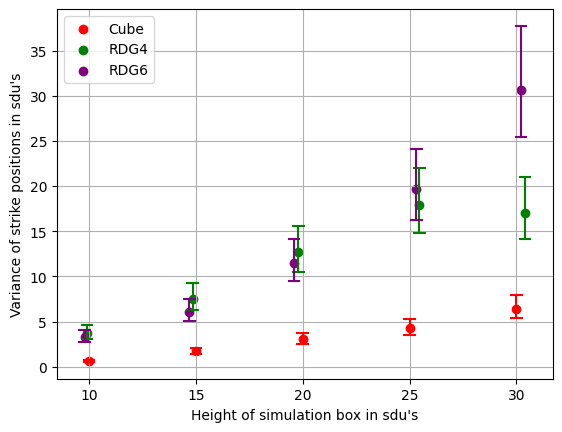

In [12]:
# Variance plot, matched with similar box heights (in sdu's)
target_heights = [10, 15, 20, 25, 30]
variances = plot_variance_plot(target_heights, height_is_cellcount=False)


Cube 20 535
Cube 25 564
RDG4 10 887
RDG6 10 938
RDG6 20 431
RDG6 25 637
RDG6 30 851


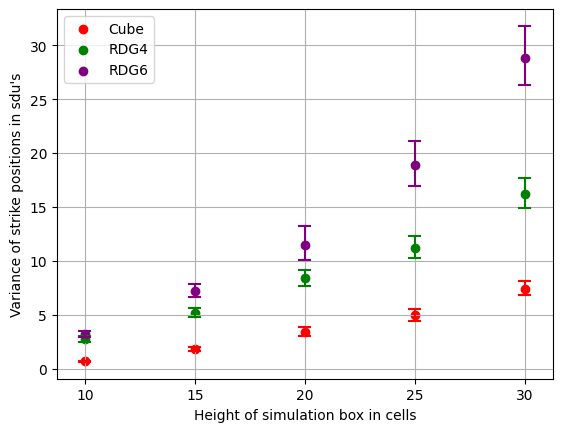

In [13]:
target_heights = [10, 15, 20, 25, 30]
variances = plot_variance_plot(target_heights, height_is_cellcount=True, datapoints_count=1000)

In [14]:
print(variances)
print(np.array(variances["RDG4"])/np.array(variances["Cube"]))
print(np.array(variances["RDG6"])/np.array(variances["RDG4"]))
print(np.array(variances["RDG6"])/np.array(variances["Cube"]))
print()
print(np.array(variances["RDG4"]) - np.array(variances["Cube"]))
print(np.array(variances["RDG6"]) - np.array(variances["Cube"]))

{'Cube': [np.float64(0.6788859422363861), np.float64(1.8018066184347932), np.float64(3.4307253407715623), np.float64(4.946765832920134), np.float64(7.4009947900103)], 'RDG4': [np.float64(2.744741986139628), np.float64(5.181212273680875), np.float64(8.389342630976838), np.float64(11.219583012017713), np.float64(16.20465609851174)], 'RDG6': [np.float64(3.1908771853836204), np.float64(7.213018565387885), np.float64(11.501335618693508), np.float64(18.88223652811218), np.float64(28.85142459077878)]}
[4.04300902 2.87556512 2.44535537 2.26806431 2.18952405]
[1.16254176 1.39214882 1.37094599 1.68297133 1.78044041]
[4.70016683 4.0032146  3.35245013 3.8170872  3.89831711]

[2.06585604 3.37940566 4.95861729 6.27281718 8.80366131]
[ 2.51199124  5.41121195  8.07061028 13.9354707  21.4504298 ]


No data for Cube with height 12
No data for Cube with height 14
No data for Cube with height 18
No data for Cube with height 19
No data for Cube with height 21
No data for Cube with height 24
No data for RDG4 with height 12
No data for RDG4 with height 18
No data for RDG4 with height 19
No data for RDG4 with height 24
No data for RDG6 with height 14
No data for RDG6 with height 18
No data for RDG6 with height 19
No data for RDG6 with height 21
No data for RDG6 with height 24


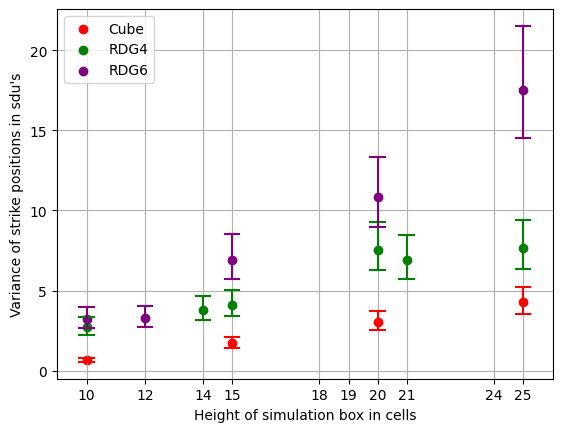

{'Cube': [np.float64(0.6509881591630666),
  np.float64(1.7126012100651373),
  np.float64(3.0500759634843284),
  np.float64(4.261161408166844)],
 'RDG4': [np.float64(2.7063667966378913),
  np.float64(3.799910794168063),
  np.float64(4.11667559308587),
  np.float64(7.553437036860568),
  np.float64(6.902829663649975),
  np.float64(7.627621892899162)],
 'RDG6': [np.float64(3.2188483066689098),
  np.float64(3.269934493604269),
  np.float64(6.931721661890709),
  np.float64(10.841933102270813),
  np.float64(17.503050880769692)]}

In [15]:
target_heights = [10, 12, 14, 15, 18, 19, 20, 21, 24, 25]
plot_variance_plot(target_heights, height_is_cellcount=True)

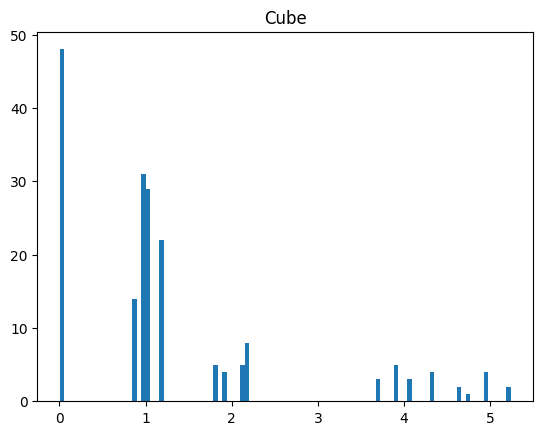

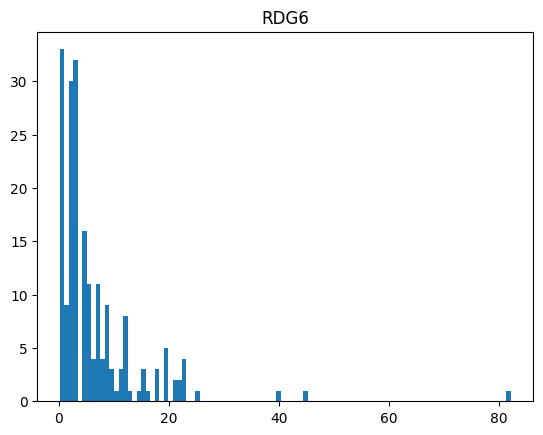

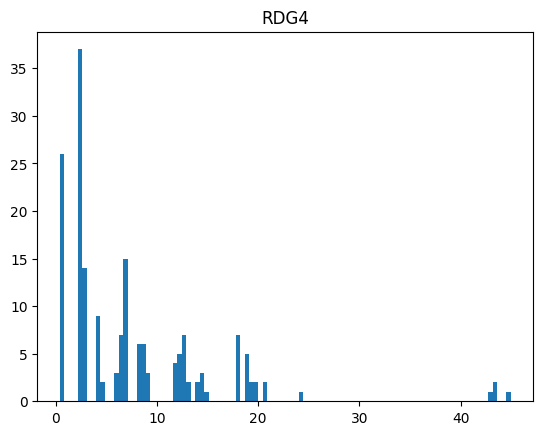

In [16]:
# Distance plots
grid_types = ["Cube", "RDG6", "RDG4"]
for grid_type in grid_types:
    target_height = 10

    all_errors = calc_variance(target_height, 6, 0.001, grid_type)[7]

    plt.hist(all_errors, bins=100)
    plt.title(grid_type)
    plt.show()

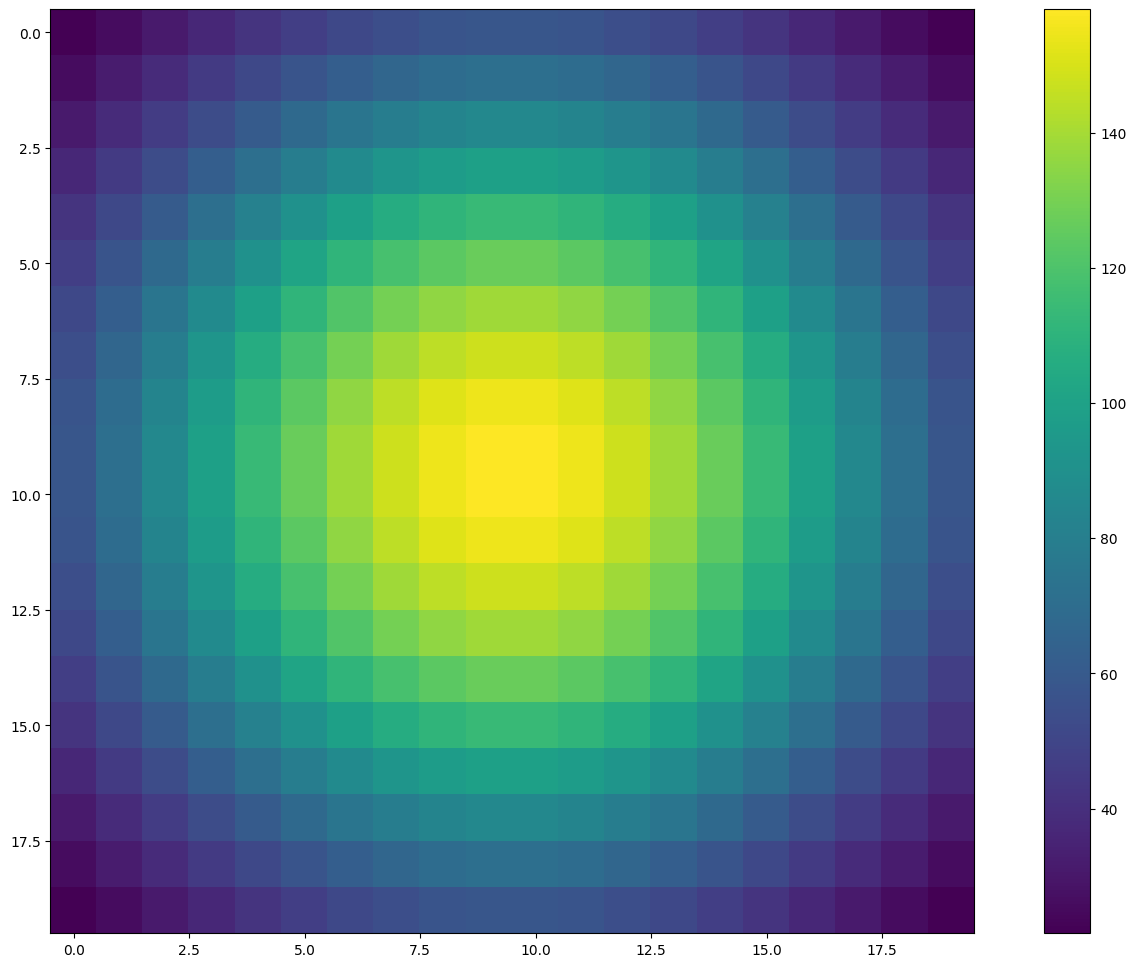

158
Average distances
24.579113924050635
24.579113924050635
24.579113924050635
Variances:
672.461065443673
672.4610654436729
671.9032629628172


In [17]:

from scipy.stats import multivariate_normal

multivariate_normal_obj = multivariate_normal([0, 0], [[2.0, 0], [0, 2]])

grid = np.array((20,20))
mg = np.meshgrid(np.linspace(-2, 2, 20), np.linspace(-2, 2, 20))
grid = multivariate_normal_obj.pdf(np.dstack(mg)) * 2000
cmap = matplotlib.cm.viridis
fig = plt.figure(figsize=(18,12))
plt.imshow(grid, cmap=cmap)
plt.colorbar()
plt.show()

grid = np.array(grid, dtype=int)

print(np.max(grid))

x_indices, y_indices = np.nonzero(grid)

#print("x_indices", x_indices)

x_data_flat = np.sum(grid, axis=1, dtype=int)
y_data_flat = np.sum(grid, axis=0, dtype=int)
#print(x_data_flat)
multiple_x_indices = []
for x in x_indices:
    multiple_x_indices.extend([x]*x_data_flat[x])

multiple_y_indices = []
for y in y_indices:
    multiple_y_indices.extend([y]*y_data_flat[y])

#print("multiple_x_indices", multiple_x_indices)
mean_x_pos = np.mean(multiple_x_indices)
mean_y_pos = np.mean(multiple_y_indices)
var_x_pos = np.var(multiple_x_indices)
var_y_pos = np.var(multiple_y_indices)

x_distances = []
y_distances = []
all_errors = []
for x in range(20):
    for y in range(20):
        x_distances.extend([(x - mean_x_pos)**2] * grid[x,y])
        y_distances.extend([(y - mean_y_pos)**2] * grid[x,y])
        all_errors.extend([((x - mean_x_pos)**2 + (y - mean_y_pos)**2)] * grid[x,y])


print("Average distances")
print(np.mean(x_distances))
print(np.mean(y_distances))
print(np.mean(all_errors)/2)
print("Variances:")
print(np.var(x_distances))
print(np.var(y_distances))
print(np.var(np.array(all_errors)/np.sqrt(2)))

In [18]:
import numpy as np

# Assuming vec1 and vec2 are already defined
vec1 = np.array([2,2,2])
vec2 = np.array([-2,-2,-2])

distance = np.linalg.norm(vec1 - vec2) * np.sqrt(2) / 8
print("Distance between vec1 and vec2:", distance)
print(np.sqrt(3)/np.sqrt(2))

vec1 = np.array([2,2,2])
vec2 = np.array([0,0,4])

distance = np.linalg.norm(vec1 - vec2) * np.sqrt(2) / 8
print("Distance between vec1 and vec2:", distance)
print(np.sqrt(6)/4)

print(2 * np.sqrt(3)/np.sqrt(2) + 8 * np.sqrt(6)/4)


Distance between vec1 and vec2: 1.2247448713915892
1.224744871391589
Distance between vec1 and vec2: 0.6123724356957946
0.6123724356957945
7.348469228349534


In [19]:
rdg6_height = 2 * np.sqrt(3)/np.sqrt(2) + 8 * np.sqrt(6)/4
print(np.sqrt(6)/3*9)
print(np.sqrt(6)/3*9 + np.sqrt(6)/2)

7.348469228349534
8.573214099741122


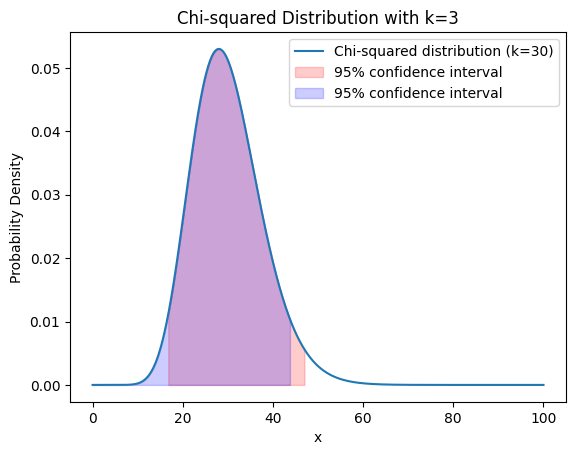

In [20]:
import numpy as np
from scipy.stats import chi2

import matplotlib.pyplot as plt

# Define the degrees of freedom
k = 30

# Define the range for the x-axis
x = np.linspace(0, 100, 1000)

# Calculate the chi-squared probability density function
y = chi2.pdf(x, k)

# Calculate the 95% confidence interval
lower_bound = chi2.ppf(0.025, k)
upper_bound = chi2.ppf(0.975, k)
lower_bound_b = chi2.ppf(0.0, k)
upper_bound_b = chi2.ppf(0.95, k)

# Plot the chi-squared distribution
plt.plot(x, y, label=f'Chi-squared distribution (k={k})')

# Shade the central 95% area under the curve
x_fill = np.linspace(lower_bound, upper_bound, 1000)
y_fill = chi2.pdf(x_fill, k)
plt.fill_between(x_fill, y_fill, alpha=0.2, color='red', label='95% confidence interval')
x_fill = np.linspace(lower_bound_b, upper_bound_b, 1000)
y_fill = chi2.pdf(x_fill, k)
plt.fill_between(x_fill, y_fill, alpha=0.2, color='blue', label='95% confidence interval')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Chi-squared Distribution with k=3')
plt.legend()

# Show the plot
plt.show()

# Percolation probability

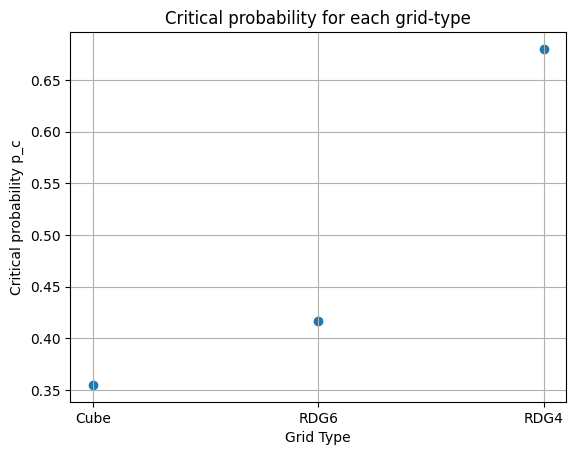

In [21]:
import matplotlib.pyplot as plt

# Cube, RDG6, RDG4
p_vals = [0.355, 0.417, 0.680]

# x-axis labels
labels = ["Cube", "RDG6", "RDG4"]

# Create scatter plot
plt.scatter(labels, p_vals)

# Add labels and title
plt.xlabel('Grid Type')
plt.ylabel('Critical probability p_c')
plt.title('Critical probability for each grid-type')
plt.grid()

# Show plot
plt.show()

# Calculate spherical concentric Hausdorff dimensionality

In [100]:
import math
def hausdorff_dim(N, nu, threshold, shape_name, lightning_size, N_is_cellcount = False, test_structure_data = []):
    if shape_name == "Cube":
        shape_name_str = "Cube\\dimensionality_data"
        N_str = str(N)
        max_width = N//2
    elif shape_name == "RDG":
        shape_name_str = "RDG\\dimensionality_data"
        width, depth, height = target_height_to_box_dim_RDG6(N, target_height_is_in_cells=N_is_cellcount)
        N_str = f"{height}"
        max_width = max(width, depth, height)
    else:
        print(f"{shape_name} is not one of the stored grid-types (Cube, RDG)")
        return
    
    # Load the file
    filename_structure = f"{__proj_dir__}\\data\\{shape_name_str}\\{N_str}_{nu}_{threshold}_{lightning_size}_structuredata.txt"
    structure_file = open(filename_structure,'r')

    # Read the file
    structure_data_str = structure_file.read()
    structure_data_str = structure_data_str.split('#')[:-1]
    structure_data = [[]]
    for structure in structure_data_str:
        points = structure.split('.')
        for point in points:
            if len(point) > 0:
                numbers = point.split(', ')
                numbers[0] = int(numbers[0].strip('('))
                numbers[1] = int(numbers[1])
                numbers[-1] = int(numbers[-1].strip(')'))
                structure_data[-1].append(numbers)
        structure_data.append([])
    structure_data = structure_data[:-1]

    if len(test_structure_data) > 0:
        structure_data = test_structure_data

    print(len(structure_data))

    center = structure_data[0][0]
    print(center)
    
    # Calculate hausdorff diminesionality
    hausdorff_results_raw = [[]]
    hausdorff_results = [[]]
    for structure in structure_data:
        # Calculate distances to center and sort
        distances = []
        for point in structure:
            distances.append(np.linalg.norm(np.array(point) - np.array(center)))
        distances.sort()

        current_index = 0
        # For each width of single box
        for radius in range(2, max_width-1):
            # Count how many points are within the radius
            while current_index < len(distances) and distances[current_index] <= radius:
                current_index += 1
            count = current_index
            hausdorff_results_raw[-1].append((radius, count))
            hausdorff_results[-1].append(np.log(count)/np.log(radius))
        hausdorff_results_raw.append([])
        hausdorff_results.append([])

    hausdorff_results = hausdorff_results[:-1]
    hausdorff_results_raw = hausdorff_results_raw[:-1]
    return hausdorff_results, hausdorff_results_raw

In [23]:
example_3d = [[i, j, k] for i in range(100) for j in range(100) for k in range(100)]
example_2d = [[50, i, j] for i in range(100) for j in range(100)]
example_1d = [[50, 50, i] for i in range(100)]
example_0d = [[50, 50, 50]]

1
[50, 50, 50]
[np.float64(7.0), np.float64(5.473919432790491), np.float64(4.811025909728189), np.float64(4.502421636845323), np.float64(4.3225683673113915), np.float64(4.154484784527181), np.float64(4.025716505196578), np.float64(3.919305270687392), np.float64(3.8216445175422167), np.float64(3.734604311587003), np.float64(3.646098703213465), np.float64(3.560999449241951), np.float64(3.4774527443558227), np.float64(3.3962646367058222), np.float64(3.3201926925326504), np.float64(3.250422235487303), np.float64(3.1865936766835095), np.float64(3.1280798930273495), np.float64(3.0745205265121034), np.float64(3.0252496262972954), np.float64(2.9797197890212335), np.float64(2.9374764335985746), np.float64(2.898138564873875), np.float64(2.8613841813402807), np.float64(2.826939060734421), np.float64(2.794568038843103), np.float64(2.7640681533355953), np.float64(2.735263199911222), np.float64(2.707999370055789), np.float64(2.682141725789403), np.float64(2.657571328368109), np.float64(2.63418288250

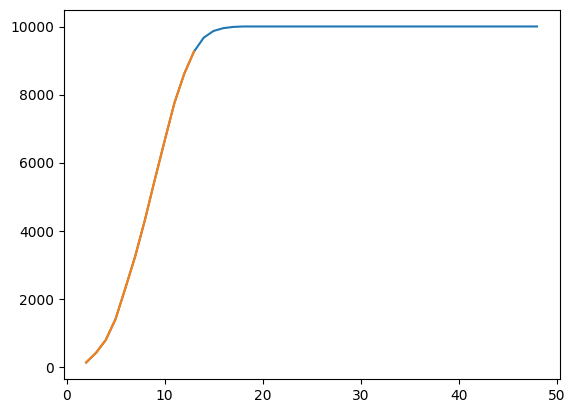

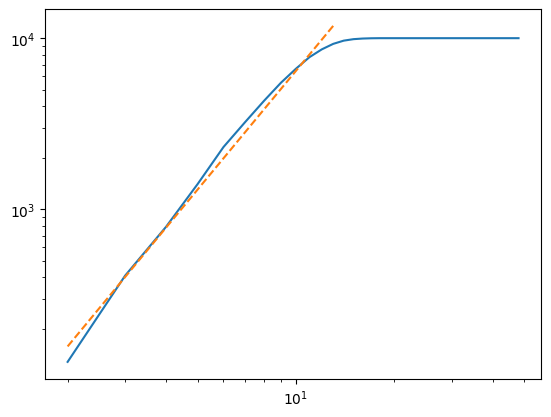

1
[50, 50, 50]
[np.float64(4.459431618637297), np.float64(3.785578521428744), np.float64(3.357122758833061), np.float64(3.2469389675367015), np.float64(3.1851988856560496), np.float64(3.113773366423592), np.float64(3.0738623737549355), np.float64(3.0394444807961984), np.float64(3.012837224705172), np.float64(2.9888869452368563), np.float64(2.968777001527737), np.float64(2.953302636354743), np.float64(2.9401359915280763), np.float64(2.9232998918927606), np.float64(2.910287149352808), np.float64(2.8938570624014073), np.float64(2.879350758384399), np.float64(2.8639493276838293), np.float64(2.8473545647336973), np.float64(2.8296870093116286), np.float64(2.8105217893521015), np.float64(2.792860257606493), np.float64(2.774619522407553), np.float64(2.7545584656615465), np.float64(2.732284707262281), np.float64(2.7083415223327405), np.float64(2.6842740950105144), np.float64(2.6605317140122673), np.float64(2.6366476627084134), np.float64(2.6139842950554004), np.float64(2.5918555011441002), np.f

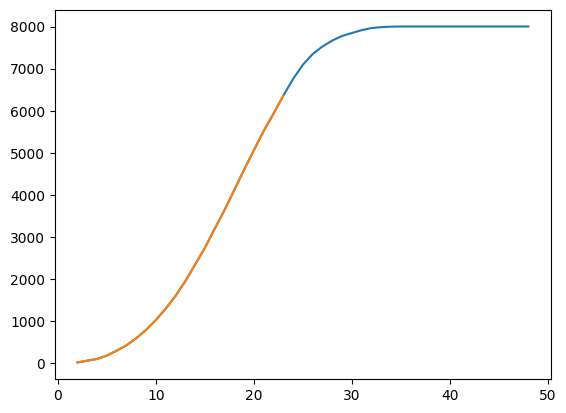

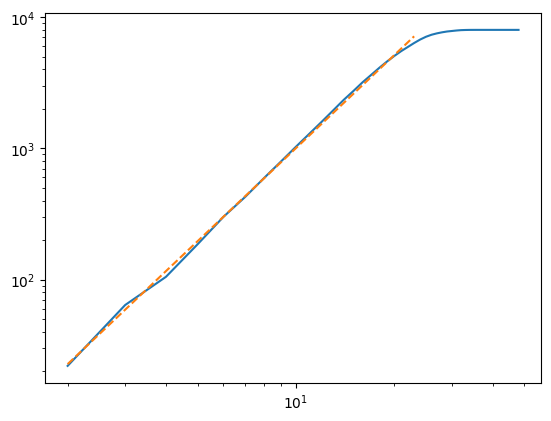

1
[50, 50, 50]
[np.float64(3.700439718141092), np.float64(3.357762781432299), np.float64(3.074873559752341), np.float64(3.0098626663592656), np.float64(2.9074695807723723), np.float64(2.8164912578325847), np.float64(2.742939563498627), np.float64(2.7022891816915373), np.float64(2.6730209071288957), np.float64(2.6441352029225533), np.float64(2.6120593041417726), np.float64(2.6041836523645863), np.float64(2.5879671733043117), np.float64(2.568135133554896), np.float64(2.5544894244660283), np.float64(2.536126349487448), np.float64(2.521795915908997), np.float64(2.5062948170515997), np.float64(2.495707793104683), np.float64(2.4897794557272883), np.float64(2.4783177770270615), np.float64(2.4694148425135247), np.float64(2.457717374684684), np.float64(2.4470153213499555), np.float64(2.4392540043772217), np.float64(2.4281220484028125), np.float64(2.4155503351453036), np.float64(2.404274510384679), np.float64(2.3928528174052452), np.float64(2.383303805967988), np.float64(2.373532969676149), np.f

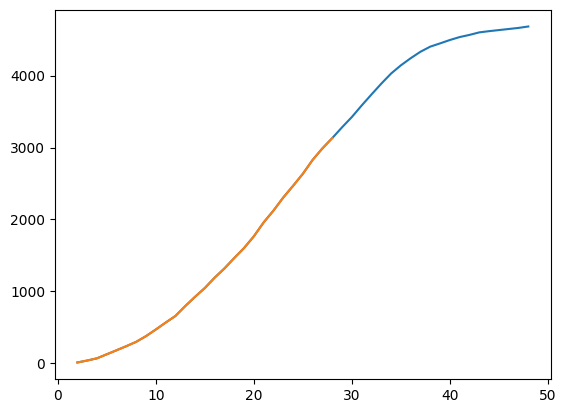

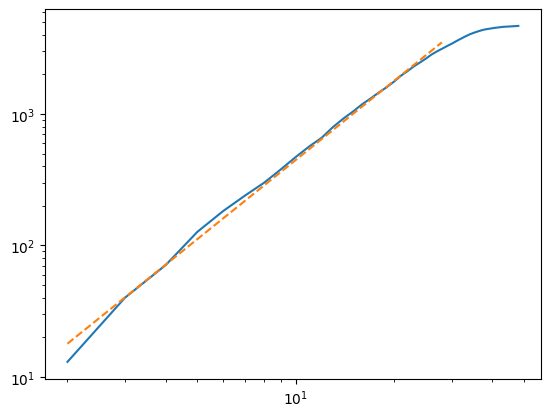

2
[50, 50, 50]
[np.float64(3.1699250014423126), np.float64(2.8927892607143724), np.float64(2.713132377351049), np.float64(2.6485519224500402), np.float64(2.5531948105033924), np.float64(2.4729735634035324), np.float64(2.4495760514103595), np.float64(2.450589310864582), np.float64(2.4393326938302624), np.float64(2.4535360051910753), np.float64(2.4476649498665677), np.float64(2.4290855604824206), np.float64(2.40847653795476), np.float64(2.3962646367058227), np.float64(2.382845365129078), np.float64(2.381187474895471), np.float64(2.373626732514854), np.float64(2.3600072107048793), np.float64(2.3451823037256143), np.float64(2.329071296772013), np.float64(2.3110706858596575), np.float64(2.2942749445523654), np.float64(2.279004167151186), np.float64(2.2640080067730226), np.float64(2.2488969270102643), np.float64(2.2331517827555865), np.float64(2.2185455598981005), np.float64(2.202651621913168), np.float64(2.1916226086543267), np.float64(2.180641065109076), np.float64(2.1697245880858675), np.

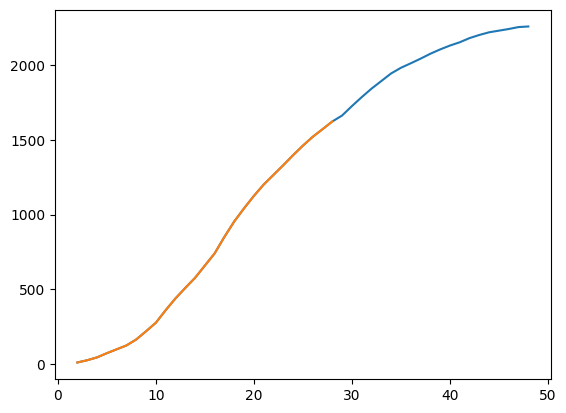

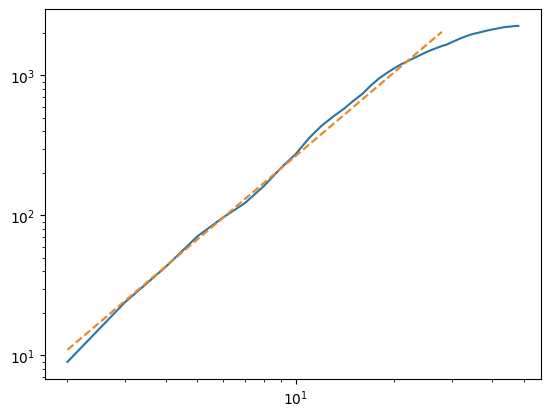

Slope of the straight part: 1.7721844511254266
nu is: 3


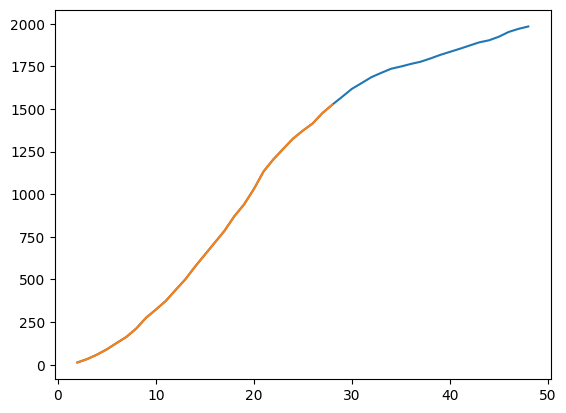

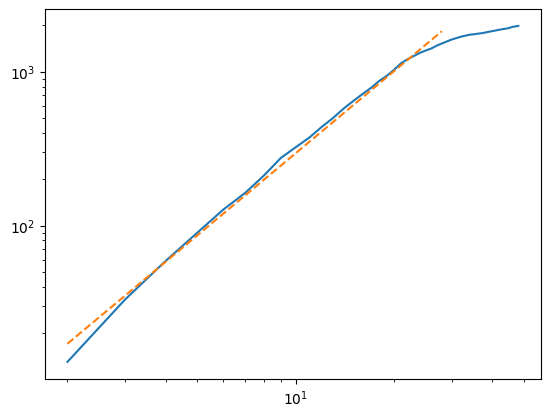

1
[50, 50, 50]
[np.float64(4.0), np.float64(3.0650447521106625), np.float64(2.7297158093186487), np.float64(2.6031788549643564), np.float64(2.5589190722379254), np.float64(2.532107501237533), np.float64(2.478209409212242), np.float64(2.435735604215902), np.float64(2.392696953259666), np.float64(2.3673902136866247), np.float64(2.3385751708107336), np.float64(2.3199844220226327), np.float64(2.3140925432766486), np.float64(2.3050618717904503), np.float64(2.2829642401521983), np.float64(2.2525010447217038), np.float64(2.231162609629447), np.float64(2.216549538214039), np.float64(2.2039979842245208), np.float64(2.198887410245868), np.float64(2.191566110325545), np.float64(2.181989506381595), np.float64(2.170099910128846), np.float64(2.157601424096627), np.float64(2.14493741988486), np.float64(2.131100306324815), np.float64(2.117828290595177), np.float64(2.1092590952435497), np.float64(2.0965848288438633), np.float64(2.0864144075475832), np.float64(2.079962391865137), np.float64(2.0728662685

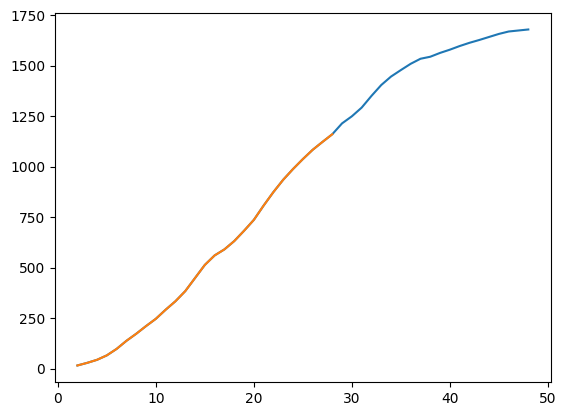

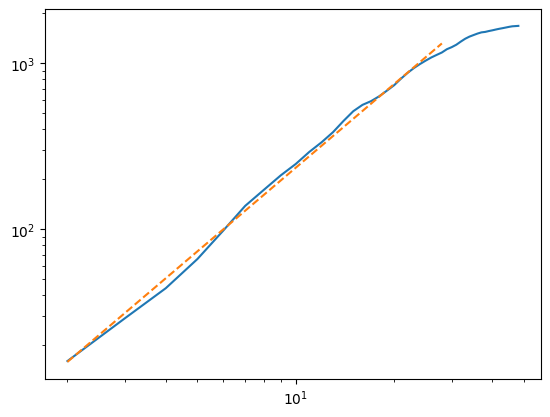

1
[50, 50, 50]
[np.float64(3.700439718141092), np.float64(2.8927892607143724), np.float64(2.604726682814475), np.float64(2.4668810662894636), np.float64(2.379046936962922), np.float64(2.2950227793522027), np.float64(2.2334799060470307), np.float64(2.1974602810768906), np.float64(2.1643528557844367), np.float64(2.158622101345237), np.float64(2.1479833377872324), np.float64(2.1334809818963594), np.float64(2.117138038533934), np.float64(2.0975137782546156), np.float64(2.084962500721156), np.float64(2.0833705819522805), np.float64(2.071170253075625), np.float64(2.064108744094127), np.float64(2.060164271652056), np.float64(2.0522242822360264), np.float64(2.0366158331471786), np.float64(2.020997423294124), np.float64(2.007022701359735), np.float64(1.9980053384621679), np.float64(1.9860674563412635), np.float64(1.9721203763752415), np.float64(1.9651312165165018), np.float64(1.958370690518233), np.float64(1.947958799371457), np.float64(1.9369821369462528), np.float64(1.9262354111407956), np.fl

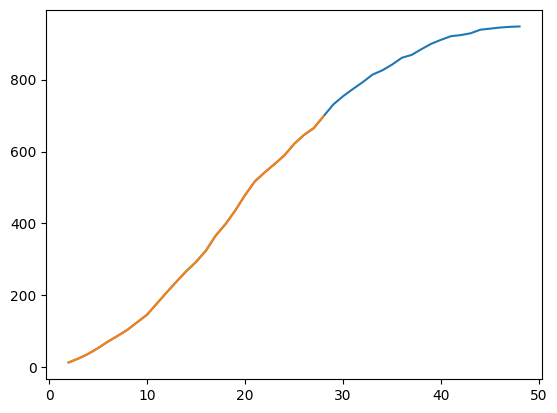

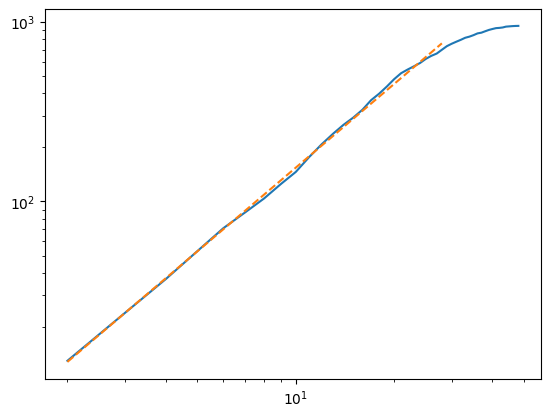

1
[50, 50, 50]
[np.float64(3.1699250014423126), np.float64(2.680143859246375), np.float64(2.3502198590705463), np.float64(2.1725022968909635), np.float64(2.2052311074341606), np.float64(2.145210698408757), np.float64(2.1191840015393617), np.float64(2.067742564475597), np.float64(2.064457989226918), np.float64(2.0331151983596603), np.float64(2.0082978115916323), np.float64(1.9835075185528983), np.float64(1.9527016471631804), np.float64(1.917599920701844), np.float64(1.8981142593170202), np.float64(1.9004905063309805), np.float64(1.899042125346519), np.float64(1.898829291444051), np.float64(1.879744672624156), np.float64(1.8657023310573735), np.float64(1.869159809482858), np.float64(1.8627499383355184), np.float64(1.8590254456206272), np.float64(1.8590143286848313), np.float64(1.8435160190953586), np.float64(1.8305172455677232), np.float64(1.8204489164996651), np.float64(1.8055833232567546), np.float64(1.7955508611963502), np.float64(1.7860864580350764), np.float64(1.7789635526615888), n

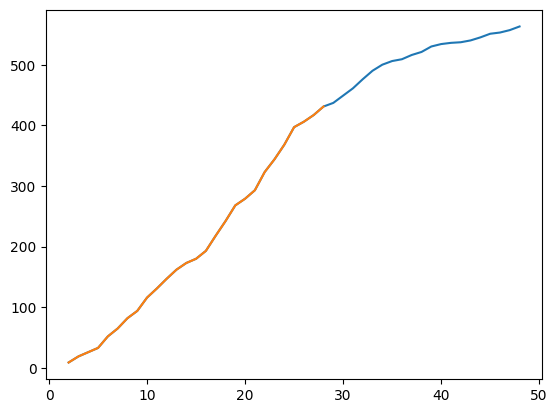

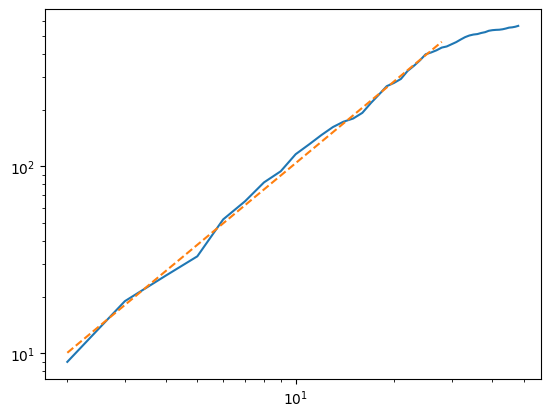

In [ ]:
is_cube = True
do_plot = True

if is_cube:
    # (nu, lightnint_size, count_cutoff)
    files_identifiers = [(0, 10000, 12), (1, 8000, 22), (2, 8000, 27), (3, 6000, 27), (4, 6000, 27), (5, 2000, 27), (6, 2000, 27)]
    N = 100
    shape_name = "Cube"
    dimensions_cube = []
else:
    files_identifiers = [(0, 500, 7), (1, 500, 10), (2, 500, 10), (3, 500, 12), (4, 500, 12), (5, 500, 20), (6, 500, 20),]
    N = 50
    shape_name = "RDG"
    dimensions_rdg = []



for nu, lightning_size, count_cutoff in files_identifiers:
    logratio_res, raw_res = hausdorff_dim(N=N, 
                                        nu=nu,
                                        threshold=0.001, 
                                        shape_name=shape_name, 
                                        lightning_size=lightning_size, 
                                        N_is_cellcount = True,
                                        test_structure_data=[])

    for res in logratio_res:
        # Fit a straight line to the straight part of the log-log plot
        straight_part = res[:20]  # Adjust the range as needed to capture the straight part
        print(res)
        x = np.log([i for i in range(1, len(straight_part)+1)])
        y = np.log([val for val in straight_part])
        slope, intercept = np.polyfit(x, y, 1)
        print(f"Slope of the straight part: {np.exp(slope)}")
        print(f"Slope: {slope}")

        if do_plot and False:
            plt.loglog(np.arange(1, len(res)+1), res)
            plt.loglog(np.arange(1, len(straight_part)+1), straight_part)
            plt.loglog(np.exp(x), np.exp(slope * x + intercept), label="Fitted Line", linestyle="--")
            plt.legend()
            plt.show()

    if is_cube:
        dimensions_cube.append([])
    else:
        dimensions_rdg.append([])
        

    all_slopes = []
    for i in range(len(raw_res)):
        # Fit a straight line to the straight part of the log-log plot
        counts = [tup[1] for tup in raw_res[i]]

        straight_counts = counts[:count_cutoff]
        x = np.log([i for i in range(2, len(straight_counts)+2)])
        y = np.log(straight_counts)
        slope, intercept = np.polyfit(x, y, 1)
        print(f"Slope of the straight part: {slope}")
        if is_cube:
            dimensions_cube[-1].append([slope])
        else:
            dimensions_rdg[-1].append([slope])

        print(f"nu is: {nu}")
        if do_plot:
            plt.plot(list(range(2, len(counts)+2)), counts)
            plt.plot(list(range(2, len(straight_counts)+2)), straight_counts)
            plt.show()
            plt.loglog(range(2, len(counts)+2), counts)
            plt.loglog(np.exp(x), np.exp(slope * x + intercept), label="Fitted Line", linestyle="--")
            plt.show()

    

7


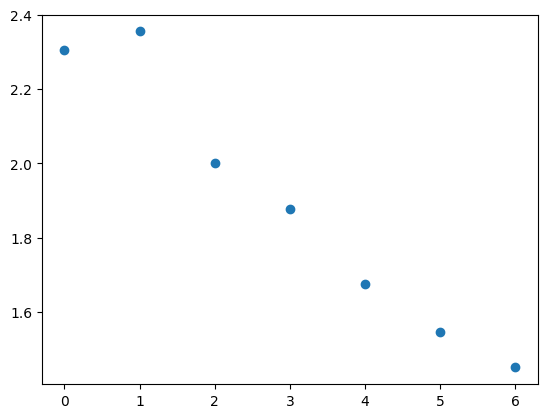

ValueError: x and y must be the same size

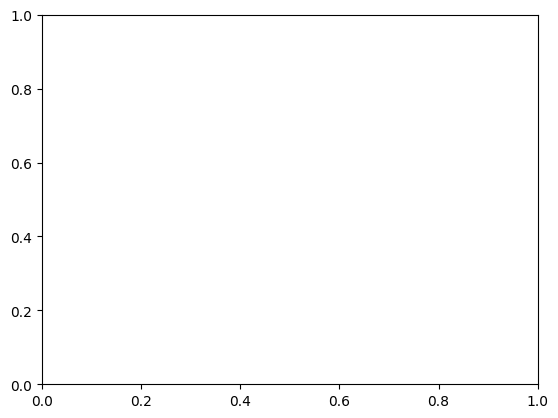

In [108]:
print(len(dimensions_cube))
plt.scatter(range(7), dimensions_cube)
plt.show()
plt.scatter(range(7), dimensions_rdg)
plt.show()